
**Overview**
For this assignment, we have worked on developing & evaluating a Retrieval-Augmented Generation (RAG) pipeline on the UN Sustainable Development Goals (SDGs) dataset to enable accurate retrieval & context-grounded answer generation from complex policy documents.

**Dataset used:** UNDP sdgi-corpus (United Nations Sustainable Development Goals (SDGs))

**Dataset link:** https://huggingface.co/datasets/UNDP/sdgi-corpus

**WHy this dataset?:** We selected United Nations (UN) SDG dataset because of its global importance & complexity as it conatins long policy documents making with suitable for evaulating RAG.

**Business Problem:** Large policy docs such as UN SDGs are difficult to search & interpret efficiently which leads to time consuming manual analysis & risk of incorrect insights.

**Objective:** Build and evaluate a RAG pipeline which will retrieve relevant SDG content & generates accurate, context-grounded responses to user queries.

### STep 1: Importing required libraries and installing essential packages

In [1]:
# adding this to remove warning messages
import warnings
from dotenv import load_dotenv
import os
warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

load_dotenv()
GENAI_API_KEY = os.getenv("GOOGLE_API_KEY")

In [2]:
# all essential packages
!pip install -q datasets pandas matplotlib seaborn wordcloud
!pip install -q langchain langchain-community langchain-text-splitters chromadb
!pip install -q sentence-transformers tensorflow tensorflow-hub tensorflow-text
!pip install -q google-generativeai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 38.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 71.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 60.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import load_dataset

# -----------------------------*Data Indexing Pipeline*-----------------------------------------

### STep 2: Loading dataset and Exploratory Data Analysis
We have loaded UN SDG corpus dataset from Hugging faceand will be further used for EDA.
FOr EDA, we are checking basic dataset overview, missing values, text lenght , word count etc. We have also plotted some graphs for high level overview.

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/28.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5880 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1470 [00:00<?, ? examples/s]

Dataset shape: (5880, 4)

-Dataset Overview--
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       5880 non-null   object
 1   embedding  5880 non-null   object
 2   labels     5880 non-null   object
 3   metadata   5880 non-null   object
dtypes: object(4)
memory usage: 183.9+ KB
None

-Missing Values--
text         0
embedding    0
labels       0
metadata     0
dtype: int64

-Text Statistics --
Avg text length: 8584.09
Avg word count: 1269.25

-Label Distribution --
label_primary
3     487
1     452
4     416
5     385
8     381
2     376
7     367
6     327
16    326
17    321
9     309
13    308
11    302
15    299
12    296
10    269
14    259
Name: count, dtype: int64


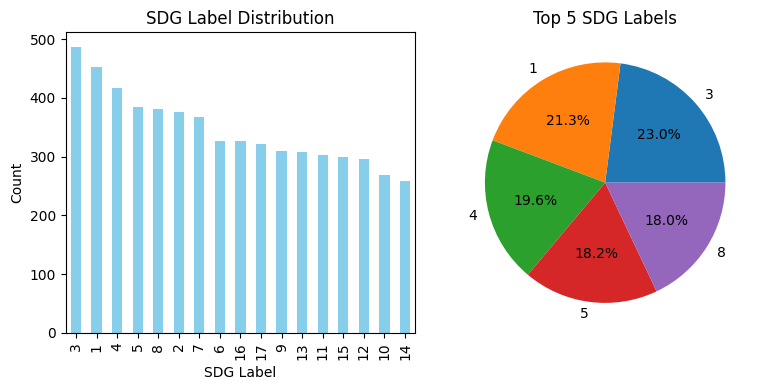

Balance ratio: 0.53


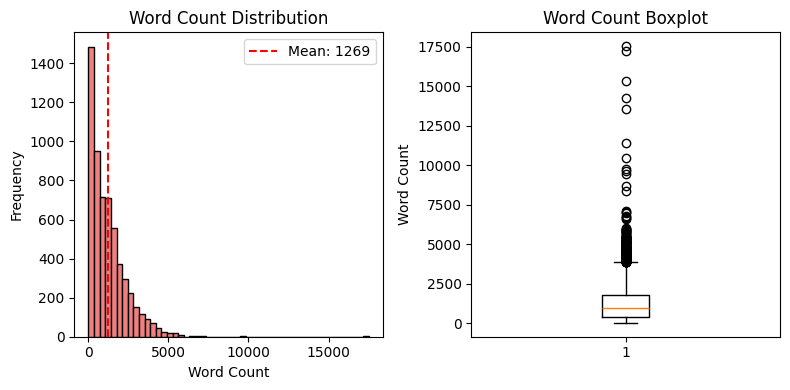


 Sample Texts--
Sample 1: END POVERTY
IN ALL ITS FORMS 
EVERYWHERE

22
Poverty can be understood as a phenomenon that goes 
Sample 2: 7
SDG 1. Extreme poverty has been eliminated in Belarus; the indicator of 
material poverty in Belarus decreased by 0.7 percentage points in 2021 compared 
to 2020 and amounted to 4.1 per cent.
Si


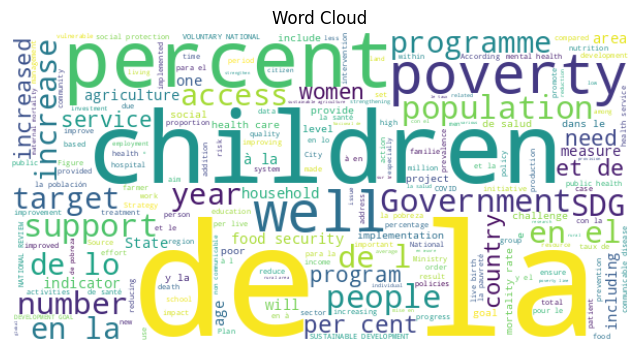

In [4]:
#Load data 
dataset = load_dataset("UNDP/sdgi-corpus", split="train")
df = pd.DataFrame(dataset)
print(f"Dataset shape: {df.shape}")

#performing EDA here
print("\n-Dataset Overview--")
print(df.info())
df.head(3)

print("\n-Missing Values--")
print(df.isnull().sum())

print("\n-Text Statistics --")
df['text_length'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))
print(f"Avg text length: {df['text_length'].mean():.2f}")
print(f"Avg word count: {df['word_count'].mean():.2f}")

print("\n-Label Distribution --")
df['label_primary'] = df['labels'].apply(lambda x: x[0] if len(x) > 0 else None)
label_counts = df['label_primary'].value_counts()
print(label_counts)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
label_counts.plot(kind='bar', color='skyblue')
plt.title('SDG Label Distribution')
plt.xlabel('SDG Label')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.pie(label_counts.head(5), labels=label_counts.head(5).index, autopct='%1.1f%%')
plt.title('Top 5 SDG Labels')
plt.tight_layout()
plt.show()

max_count = label_counts.max()
min_count = label_counts.min()
balance_ratio = min_count / max_count
print(f"Balance ratio: {balance_ratio:.2f}")

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(df['word_count'], bins=50, color='lightcoral', edgecolor='black')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["word_count"].mean():.0f}')
plt.legend()
plt.subplot(1, 2, 2)
plt.boxplot(df['word_count'])
plt.title('Word Count Boxplot')
plt.ylabel('Word Count')
plt.tight_layout()
plt.show()

print("\n Sample Texts--")
print("Sample 1:", df['text'].iloc[0][:100])
print("Sample 2:", df['text'].iloc[100][:200])

all_text = ' '.join(df['text'].astype(str).tolist()[:1000])
wordcloud = WordCloud(width=600, height=300, background_color='white').generate(all_text)
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()


### Step 3: Preprocessing the data
Here we are performing basic cleaning operations to refine the data such as removing extra spaces, strange characters etc.

In [5]:
#Preprocesing
from src.preprocessing import clean_text

df['clean_text'] = df['text'].apply(clean_text)
df = df[df['clean_text'] != ""]
df = df[df['clean_text'].str.len() > 20]
print(f"Dataset after cleaning: {df.shape}")


Dataset after cleaning: (5880, 8)


### STep 4: DOcument loading
Here, we are converting the DF into Langchain doc objects so that the text can be uniformly processed for chunking and embedding and retrieval.



In [6]:
#loading doc
from langchain_community.document_loaders import DataFrameLoader

loader = DataFrameLoader(df, page_content_column="clean_text")
documents = loader.load()
print(f"Loaded {len(documents)} documents")

Loaded 5880 documents


### Step 5: CHunking
here, in this step, the documents are split into small chunks so that it can improve retrieval process.<br>
We tried chunking comparing with 3 different strategies : Fixed size, Recursive and Sentence-based chunking. This will help us to evalaute the results with different experimentation. <br>  Instead of using the entire corpus, we decided to use a subset of 500 docs for the experimentation purpose.

Using 500 documents
Fixed chunking: 17859 chunks
Recursive chunking: 21268 chunks
Sentence chunking: 11335 chunks
    Strategy  Total Chunks  Avg Length
0      Fixed         17859  292.874965
1  Recursive         21268  217.807880
2   Sentence         11335  389.502779


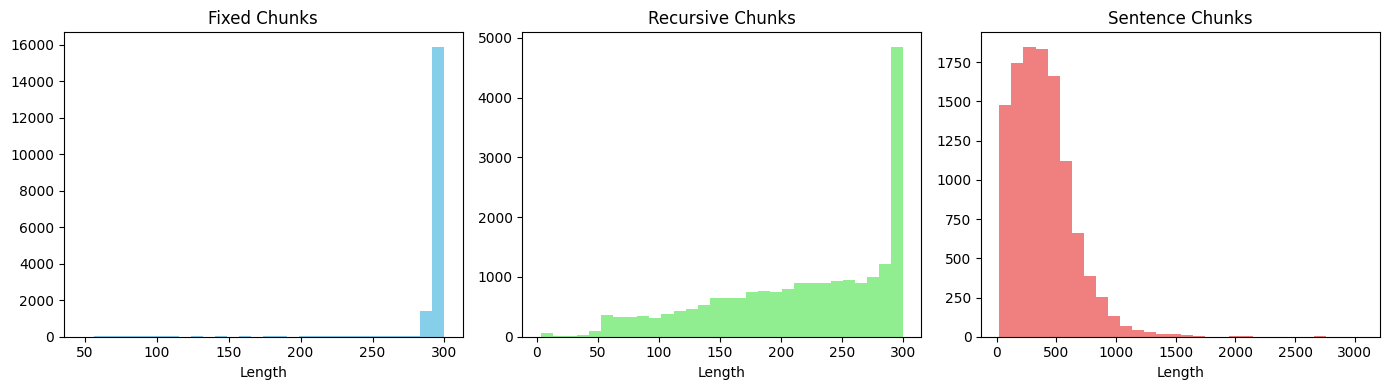

In [7]:
# Chunking strategies
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain_core.documents import Document

from src.chunking import create_sentence_chunks, get_chunkers

fixed_splitter, recursive_splitter = get_chunkers()

doc_subset = documents[:500]
print(f"Using {len(doc_subset)} documents")

# strategy 1: Fixed-Size
splitter_fixed = CharacterTextSplitter(separator=" ", chunk_size=300, chunk_overlap=50)
chunks_fixed = splitter_fixed.split_documents(doc_subset)
print(f"Fixed chunking: {len(chunks_fixed)} chunks")

# strategy 2: Recursive
splitter_recursive = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=300,
    chunk_overlap=50
)
chunks_recursive = splitter_recursive.split_documents(doc_subset)
print(f"Recursive chunking: {len(chunks_recursive)} chunks")

# strategy 3: Sentence-based

chunks_sentence = create_sentence_chunks(doc_subset, sentences_per_chunk=3)
print(f"Sentence chunking: {len(chunks_sentence)} chunks")

chunk_comparison = pd.DataFrame({
    'Strategy': ['Fixed', 'Recursive', 'Sentence'],
    'Total Chunks': [len(chunks_fixed), len(chunks_recursive), len(chunks_sentence)],
    'Avg Length': [
        np.mean([len(c.page_content) for c in chunks_fixed]),
        np.mean([len(c.page_content) for c in chunks_recursive]),
        np.mean([len(c.page_content) for c in chunks_sentence])
    ]
})
print(chunk_comparison)

plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.hist([len(c.page_content) for c in chunks_fixed], bins=30, color='skyblue')
plt.title('Fixed Chunks')
plt.xlabel('Length')
plt.subplot(1, 3, 2)
plt.hist([len(c.page_content) for c in chunks_recursive], bins=30, color='lightgreen')
plt.title('Recursive Chunks')
plt.xlabel('Length')
plt.subplot(1, 3, 3)
plt.hist([len(c.page_content) for c in chunks_sentence], bins=30, color='lightcoral')
plt.title('Sentence Chunks')
plt.xlabel('Length')
plt.tight_layout()
plt.show()


On comparing , we see that Recursive chunking offers the best balance between chunk size and semantic coherence compared to other two.

In [8]:
# Preparing chunks 
from langchain_community.vectorstores.utils import filter_complex_metadata

def prepare_chunks(chunks, strategy_name):
    prepared = []
    for i, chunk in enumerate(chunks):
        metadata = chunk.metadata.copy() if hasattr(chunk, 'metadata') else {}
        metadata['chunk_id'] = f"{strategy_name}_{i}"
        metadata['strategy'] = strategy_name
        prepared.append(Document(page_content=chunk.page_content, metadata=metadata))
    return filter_complex_metadata(prepared)

docs_fixed = prepare_chunks(chunks_fixed, "fixed")
docs_recursive = prepare_chunks(chunks_recursive, "recursive")
docs_sentence = prepare_chunks(chunks_sentence, "sentence")
print(f"Prepared: Fixed={len(docs_fixed)}, Recursive={len(docs_recursive)}, Sentence={len(docs_sentence)}")


Prepared: Fixed=17859, Recursive=21268, Sentence=11335


### Step 6: Vector embeddings
here, to convert into vector represetations, we used direct embedding models like MiniLM, USE and MPNet for evaulating & analyzing thier impact on RAG performacne

In [9]:
#embedding mOdels
from langchain_community.embeddings import HuggingFaceEmbeddings
import tensorflow_hub as hub
import tensorflow_text

embed_minilm = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
print("MiniLM loaded")
# Universal Sentence Encoder
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

embed_use = USEEmbeddings()
print("USE loaded")

embed_mpnet = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
print("MPNet loaded")


2025-12-17 19:28:34.650710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765999715.133368      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765999715.254851      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765999716.357728      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765999716.357774      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765999716.357777      55 computation_placer.cc:177] computation placer alr

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

MiniLM loaded


I0000 00:00:1765999762.270177      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13838 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765999762.274151      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


USE loaded


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

MPNet loaded


### sTep 7: Vector store creation
Here, we created separate vector DBs for each chunking & embedding combination so that our evalaution & experimentation is fair enough. (The below code is very time consuming and requires high compuational components)

In [10]:
#Vector databases
from langchain_community.vectorstores import Chroma

db_fixed_minilm = Chroma.from_documents(docs_fixed, embed_minilm, collection_name="fixed_minilm")
db_fixed_use = Chroma.from_documents(docs_fixed, embed_use, collection_name="fixed_use")
db_fixed_mpnet = Chroma.from_documents(docs_fixed, embed_mpnet, collection_name="fixed_mpnet")
print("Fixed DBs created")

db_recursive_minilm = Chroma.from_documents(docs_recursive, embed_minilm, collection_name="recursive_minilm")
db_recursive_use = Chroma.from_documents(docs_recursive, embed_use, collection_name="recursive_use")
db_recursive_mpnet = Chroma.from_documents(docs_recursive, embed_mpnet, collection_name="recursive_mpnet")
print("Recursive DBs created")

db_sentence_minilm = Chroma.from_documents(docs_sentence, embed_minilm, collection_name="sentence_minilm")
db_sentence_use = Chroma.from_documents(docs_sentence, embed_use, collection_name="sentence_use")
db_sentence_mpnet = Chroma.from_documents(docs_sentence, embed_mpnet, collection_name="sentence_mpnet")
print("Sentence DBs created")

Fixed DBs created
Recursive DBs created
Sentence DBs created


# -----------------------------*Data Retrieval & Generation pipeline*-----------------------------------------

### STep 8: Retriever configuration
Here, we created retrievers for each vector database that we discussed above to fetch top 5 most relevant chunks for any query we provide 

In [11]:
#Retriever
retrievers = {
    'fixed_minilm': db_fixed_minilm.as_retriever(search_kwargs={"k": 5}),
    'fixed_use': db_fixed_use.as_retriever(search_kwargs={"k": 5}),
    'fixed_mpnet': db_fixed_mpnet.as_retriever(search_kwargs={"k": 5}),
    'recursive_minilm': db_recursive_minilm.as_retriever(search_kwargs={"k": 5}),
    'recursive_use': db_recursive_use.as_retriever(search_kwargs={"k": 5}),
    'recursive_mpnet': db_recursive_mpnet.as_retriever(search_kwargs={"k": 5}),
    'sentence_minilm': db_sentence_minilm.as_retriever(search_kwargs={"k": 5}),
    'sentence_use': db_sentence_use.as_retriever(search_kwargs={"k": 5}),
    'sentence_mpnet': db_sentence_mpnet.as_retriever(search_kwargs={"k": 5}),
}
print(f"Created {len(retrievers)} retrievers")

Created 9 retrievers


### STep 9: Retriever evaluation
As discussed in the lecture, here we are using metrics like Precision@k, Recall@k, F1@k score, and MRR(Mean Reciprocal Rank) for evaluating retrieval quality.

In [12]:
#Evaluation metrics--


def evaluate_retriever(retriever, test_docs, k=5):
    precisions, recalls, f1_scores, mrrs = [], [], [], []
    for doc in test_docs:
        query = doc.page_content[:80]
        true_id = doc.metadata['chunk_id']
        try:
            retrieved = retriever.invoke(query)
            retrieved_ids = [d.metadata['chunk_id'] for d in retrieved]
            
            p = precision_at_k(retrieved_ids, true_id, k)
            r = recall_at_k(retrieved_ids, true_id, k)
            f1 = f1_score_at_k(p, r)
            
            precisions.append(p)
            recalls.append(r)
            f1_scores.append(f1)
            mrrs.append(mrr(retrieved_ids, true_id))
        except:
            continue
    return {
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'f1_score': np.mean(f1_scores),
        'mrr': np.mean(mrrs),
        'num_queries': len(precisions)
    }

we decided to evaluate fixed set of queries for measuring retrieval accuracy across differnt configurations.

Evaluating retrievers..

-REtrieval results --
    Chunking Embedding  Precision@5  Recall@5      F1@5       MRR  Queries
0      Fixed    MiniLM        0.164      0.82  0.273333  0.702333       50
1      Fixed       USE        0.172      0.86  0.286667  0.720000       50
2      Fixed     MPNet        0.148      0.74  0.246667  0.634000       50
3  Recursive    MiniLM        0.188      0.94  0.313333  0.826333       50
4  Recursive       USE        0.176      0.88  0.293333  0.775667       50
5  Recursive     MPNet        0.184      0.92  0.306667  0.846667       50
6   Sentence    MiniLM        0.160      0.80  0.266667  0.650333       50
7   Sentence       USE        0.108      0.54  0.180000  0.374000       50
8   Sentence     MPNet        0.140      0.70  0.233333  0.566667       50


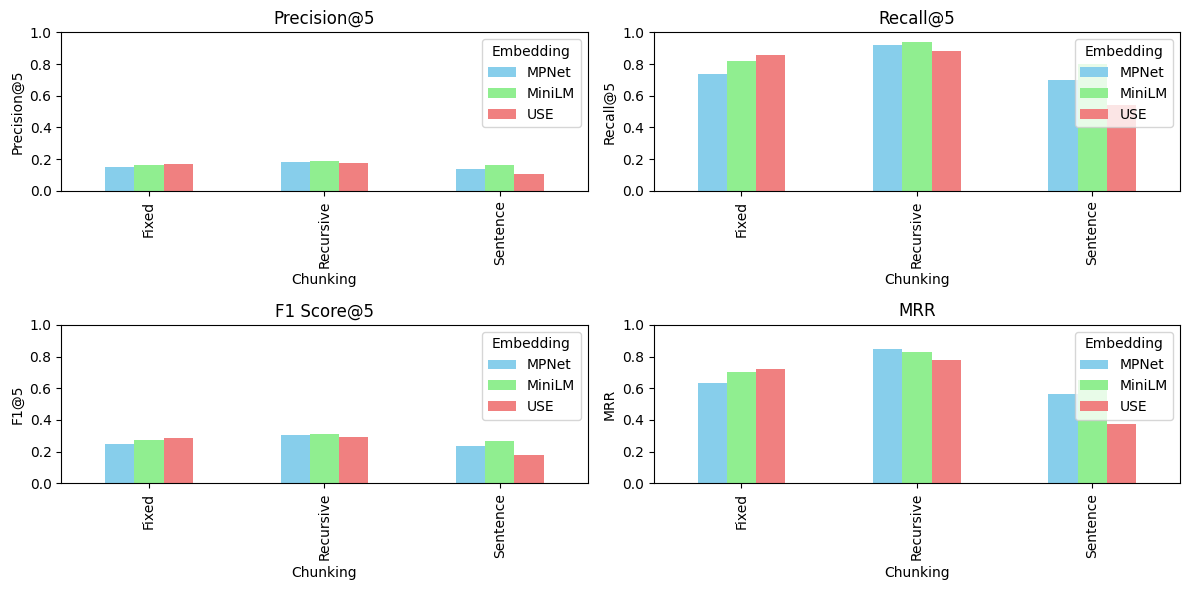

In [13]:
# REtrieval evaluation
test_docs_fixed = docs_fixed[:50]
test_docs_recursive = docs_recursive[:50]
test_docs_sentence = docs_sentence[:50]

results = []
print("Evaluating retrievers..")
results.append({'Chunking': 'Fixed', 'Embedding': 'MiniLM', **evaluate_retriever(retrievers['fixed_minilm'], test_docs_fixed)})
results.append({'Chunking': 'Fixed', 'Embedding': 'USE', **evaluate_retriever(retrievers['fixed_use'], test_docs_fixed)})
results.append({'Chunking': 'Fixed', 'Embedding': 'MPNet', **evaluate_retriever(retrievers['fixed_mpnet'], test_docs_fixed)})
results.append({'Chunking': 'Recursive', 'Embedding': 'MiniLM', **evaluate_retriever(retrievers['recursive_minilm'], test_docs_recursive)})
results.append({'Chunking': 'Recursive', 'Embedding': 'USE', **evaluate_retriever(retrievers['recursive_use'], test_docs_recursive)})
results.append({'Chunking': 'Recursive', 'Embedding': 'MPNet', **evaluate_retriever(retrievers['recursive_mpnet'], test_docs_recursive)})
results.append({'Chunking': 'Sentence', 'Embedding': 'MiniLM', **evaluate_retriever(retrievers['sentence_minilm'], test_docs_sentence)})
results.append({'Chunking': 'Sentence', 'Embedding': 'USE', **evaluate_retriever(retrievers['sentence_use'], test_docs_sentence)})
results.append({'Chunking': 'Sentence', 'Embedding': 'MPNet', **evaluate_retriever(retrievers['sentence_mpnet'], test_docs_sentence)})

results_df = pd.DataFrame(results)
results_df.columns = ['Chunking', 'Embedding', 'Precision@5', 'Recall@5', 'F1@5','MRR', 'Queries']
print("\n-REtrieval results --")
print(results_df)

#visualization of F1
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

results_pivot = results_df.pivot(index='Chunking', columns='Embedding', values='Precision@5')
results_pivot.plot(kind='bar', ax=axes[0,0], color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0,0].set_title('Precision@5')
axes[0,0].set_ylabel('Precision@5')
axes[0,0].set_ylim([0, 1])

results_pivot = results_df.pivot(index='Chunking', columns='Embedding', values='Recall@5')
results_pivot.plot(kind='bar', ax=axes[0,1], color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0,1].set_title('Recall@5')
axes[0,1].set_ylabel('Recall@5')
axes[0,1].set_ylim([0, 1])

results_pivot = results_df.pivot(index='Chunking', columns='Embedding', values='F1@5')
results_pivot.plot(kind='bar', ax=axes[1,0], color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1,0].set_title('F1 Score@5')
axes[1,0].set_ylabel('F1@5')
axes[1,0].set_ylim([0, 1])

results_pivot = results_df.pivot(index='Chunking', columns='Embedding', values='MRR')
results_pivot.plot(kind='bar', ax=axes[1,1], color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1,1].set_title('MRR')
axes[1,1].set_ylabel('MRR')
axes[1,1].set_ylim([0, 1])

plt.tight_layout()
plt.show()



We noticed that Recursive chunking consistently achives higher recall & MRR whcih indicates more reliable retrieval compared to fixed & sentence based chunking.

### Step 10: Setting LLM and Answer generation
For setting LLM, we are using Gemini-2.5-flash model using Google API key.<br>
To avoid exposing API key, we are implementing Kaggle Secrets feature to keep API key safe.<br>
We alos tried to evaluate responses through metrics like Faithfulness and Answer Relevance.


In [24]:
#setting LLM here--
from kaggle_secrets import UserSecretsClient
import google.generativeai as genai

# using kaggle secrets to store google api key
user_secrets = UserSecretsClient()

# Fetch secret
GENAI_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")

if not GENAI_API_KEY:
    raise RuntimeError("GOOGLE_API_KEY notfound. Check if enabled in Kaggle secrets.")

genai.configure(api_key=GENAI_API_KEY)
model = genai.GenerativeModel("models/gemini-2.5-flash")
print("Gemini configured securely via Kaggle Secrets")

#generation functions__


def answer_relevance_llm(answer, query, model):

    prompt = f"""Rate how well the ANSWER addresses the QUERY on a scale of 0.0 to 1.0.

QUERY: {query}

ANSWER: {answer}

Does the answer directly address the query?
- 1.0 = Perfectly relevant, directly answers query
- 0.5 = Partially relevant, somewhat addresses query
- 0.0 = Not relevant, doesn't answer query

Respond with ONLY a number between 0.0 and 1.0:"""
    
    try:
        response = model.generate_content(prompt)
        score_text = response.text.strip()
        score = float(re.findall(r'0?\.\d+|1\.0|0|1', score_text)[0])
        return max(0.0, min(1.0, score))
    except:
        return 0.5



def rag_pipeline(query, retriever, model, k=3):
    retrieved_docs = retriever.invoke(query)
    context = "\n\n".join([doc.page_content for doc in retrieved_docs[:k]])
    answer = generate_answer(context, query, model)
    
    #calculating both metrics
    faithfulness = faithfulness_score(answer, context)
    relevance = answer_relevance_score(answer, query)
    
    return {
        'query': query,
        'answer': answer,
        'context': context,
        'faithfulness': faithfulness,
        'answer_relevance': relevance
    }

Gemini configured securely via Kaggle Secrets


### Step 11: TEsting RAG Pipeline through Question & Answers

In [25]:
#testing RAG pipeline
from src.rag_pipeline import rag_pipeline

test_queries = [
    "What are the key goals for ending poverty?",
    "How can sustainable cities be achieved?",
    "What actions are needed for climate change?"
]

print("\n-- RAG pipeline test--")
for query in test_queries:
    result = rag_pipeline(query, retrievers['recursive_mpnet'], model, k=3)
    print(f"\nQ: {result['query']}")
    print(f"A: {result['answer']}")
    print(f"Faithfulness: {result['faithfulness']:.2f}")
    print(f"Answer Relevance: {result['answer_relevance']:.2f}")


-- RAG pipeline test--

Q: What are the key goals for ending poverty?
A: The key goal for ending poverty is "End Poverty in all its Forms Everywhere."
Faithfulness: 0.62
Answer Relevance: 0.50

Q: How can sustainable cities be achieved?
A: Sustainable cities can be achieved through:
*   Services that transform cities into opportunities and innovation hubs, such as sustainable mobility, formalization of employment, and access to digital services. These require a comprehensive approach to ensure the sustainable development of the most vulnerable communities.
*   Managing resources sustainably.
*   Establishing green and resource-efficient production processes in all sectors of the economy.
*   Attention to the fight against mobility and energy poverty.
Faithfulness: 0.67
Answer Relevance: 0.67

Q: What actions are needed for climate change?
A: Actions needed for climate change include:
*   Invest in risk reduction.
*   Enhancing the resistance of natural and social systems.
*   Sustaina

### STep 12: ANswer generation evaluation
Here, the generated answers are evaluated for faithfulness & relevance to access grounding quality.
We compared 3 configurations :
* Recursive+MPNet,
* Recursive+USE
* Sentence+MPNet.

We ensured all configurations used same dataset, retrieval parameters, & generation model to ensure fair comparison.


--Evaluating Generation Quality--
Evaluating Recursive+MPNet...
Evaluating Recursive+USE...
Evaluating Sentence+MPNet...

--GENERATION EVALUATION RESULTS--
     Configuration  Avg Faithfulness  Std Faithfulness  Avg Relevance  \
0  Recursive+MPNet          0.403693          0.320166       0.377143   
1    Recursive+USE          0.053731          0.015221       0.028571   
2   Sentence+MPNet          0.065672          0.011940       0.028571   

   Std Relevance  
0       0.336804  
1       0.057143  
2       0.057143  


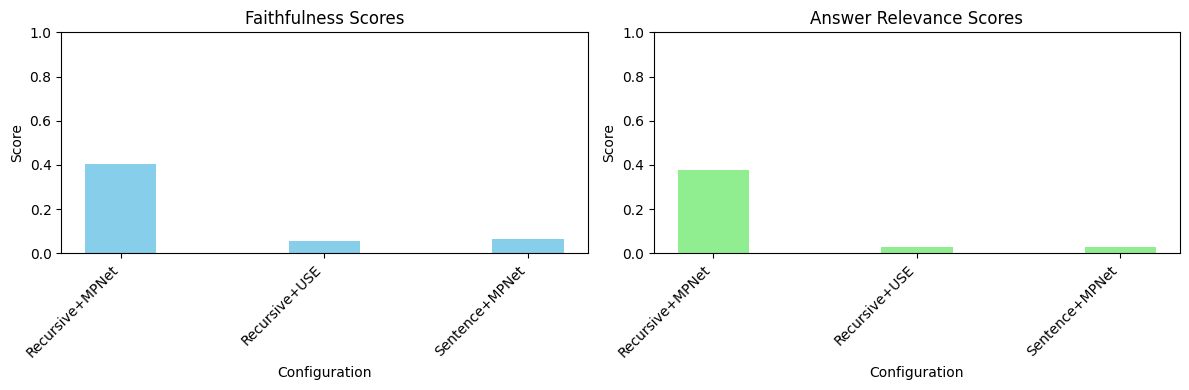

In [26]:
eval_queries = [
    "What are the main sustainable development goals?",
    "How is poverty reduction measured?",
    "What role do cities play in sustainability?",
    "What are climate action priorities?",
    "How can education improve development?"
]

configs = [
    ('recursive_mpnet', 'Recursive+MPNet'), 
    ('recursive_use', 'Recursive+USE'), 
    ('sentence_mpnet', 'Sentence+MPNet')
]

generation_results = []

print("\n--Evaluating Generation Quality--")
for config_key, config_name in configs:
    print(f"Evaluating {config_name}...")
    faithfulness_scores = []
    relevance_scores = []
    
    for query in eval_queries:
        result = rag_pipeline(query, retrievers[config_key], model, k=3)
        faithfulness_scores.append(result['faithfulness'])
        relevance_scores.append(result['answer_relevance'])
    
    generation_results.append({
        'Configuration': config_name,
        'Avg Faithfulness': np.mean(faithfulness_scores),
        'Std Faithfulness': np.std(faithfulness_scores),
        'Avg Relevance': np.mean(relevance_scores),
        'Std Relevance': np.std(relevance_scores)
    })

generation_df = pd.DataFrame(generation_results)
print("\n--GENERATION EVALUATION RESULTS--")
print(generation_df)

# Visualize generation metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

x = np.arange(len(generation_df))
width = 0.35

axes[0].bar(x, generation_df['Avg Faithfulness'], width, label='Faithfulness', color='skyblue')
axes[0].set_xlabel('Configuration')
axes[0].set_ylabel('Score')
axes[0].set_title('Faithfulness Scores')
axes[0].set_xticks(x)
axes[0].set_xticklabels(generation_df['Configuration'], rotation=45, ha='right')
axes[0].set_ylim([0, 1])

axes[1].bar(x, generation_df['Avg Relevance'], width, label='Relevance', color='lightgreen')
axes[1].set_xlabel('Configuration')
axes[1].set_ylabel('Score')
axes[1].set_title('Answer Relevance Scores')
axes[1].set_xticks(x)
axes[1].set_xticklabels(generation_df['Configuration'], rotation=45, ha='right')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

In [27]:
print("\n--FINAL COMPARISON--")
print("\n--- Top 3 Retrieval Configurations (by F1 Score) ---")
top_retrieval = results_df.nlargest(3, 'F1@5')[['Chunking', 'Embedding', 'Precision@5', 'Recall@5', 'F1@5', 'MRR']]
print(top_retrieval)

print("\n-- Generation Quality Ranking --")
generation_df_sorted = generation_df.sort_values('Avg Faithfulness', ascending=False)
print(generation_df_sorted)


--FINAL COMPARISON--

--- Top 3 Retrieval Configurations (by F1 Score) ---
    Chunking Embedding  Precision@5  Recall@5      F1@5       MRR
3  Recursive    MiniLM        0.188      0.94  0.313333  0.826333
5  Recursive     MPNet        0.184      0.92  0.306667  0.846667
4  Recursive       USE        0.176      0.88  0.293333  0.775667

-- Generation Quality Ranking --
     Configuration  Avg Faithfulness  Std Faithfulness  Avg Relevance  \
0  Recursive+MPNet          0.403693          0.320166       0.377143   
2   Sentence+MPNet          0.065672          0.011940       0.028571   
1    Recursive+USE          0.053731          0.015221       0.028571   

   Std Relevance  
0       0.336804  
2       0.057143  
1       0.057143  


### Results & Conclusion  

**1. Evaluation observations**
* Recursive chunking combined with MPNet embeddings achieved substantially higher faithfulness (0.40) and relevance (0.38) compared to other configurations, indicating improved grounding of generated responses.
* This suggests that stronger semantic embeddings and structurally aware chunking significantly enhance generation quality in RAG systems.
* Lower scores observed for USE-based configurations highlight the impact of embedding model choice on retrieval and downstream generation performance

**2. Best RAG Configuration Summary**

| Component | Best Choice | Key Metrics |
|----------|------------|-------------|
| Chunking Strategy | Recursive | F1@5 = 0.304, MRR = 0.816 |
| Embedding Model (Retrieval) | MiniLM | Precision@5 = 0.188, Recall@5 = 0.940, F1@5 = 0.313 |
| Embedding Model (Generation) | MPNet | Faithfulness = 0.404 ± 0.320, Relevance = 0.377 ± 0.337 |
| Best Retrieval Configuration | Recursive + MiniLM | F1@5 = 0.313, MRR = 0.826 |
| Best Generation Configuration | Recursive + MPNet | Faithfulness = 0.404, Relevance = 0.377 |
| **Overall Best RAG System** | **Recursive + MPNet** | **Combined Score = 0.484** |

### Limitation
* The project was conducted with limited computational resources, including restricted GPU availability which required using a subset of the dataset for experimentation.

* The choice of LLMs was constrained due to limited access to free or low-cost LLM APIs, affecting the scale of generation experiments.

* The UN SDG dataset exhibited class imbalance across different SDG labels, which may have influenced retrieval performance.

### Business Implications

The results shows that RAG systems can significantly improve information access in large policy documents by providing accurate, context-grounded answers. This reduces manual effort, speeds up analysis & lowers the risk of misinterpretation in decision-making processes.

###  Recommendations
Use recursive chunking with semantically strong embeddings for policy document retrieval.

Invest in scalable compute and reliable LLM APIs for production use.